In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from LaPlaceNet import LaPlaceNet
from machine_learning import *
from util import *
from hessian import exact_hessian

In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [4]:
# Set up device
device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda:1 device NVIDIA TITAN V


In [5]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
#n_data = [500, 1000, 2000, 3000, 5000]
patience = 70
load_ensemble_values = True

#Data constants
shapes = [2, 6]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes
grid_rmax=20

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
grid_rmax = grid_data["x1"].max()

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [6]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [7]:
model = LaPlaceBinaryNet(L=200, in_channels=2, out_channels=2).to(device)
#model = SequentialNet(L=5000, n_hidden=4, activation="relu", in_channels=2, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
model # Check that everything looks good

NameError: name 'LaPlaceBinaryNet' is not defined

100%|██████████| 100/100 [00:00<00:00, 560.74it/s]


Text(0.5, 0.98, 'Number of training datapoints: 0')

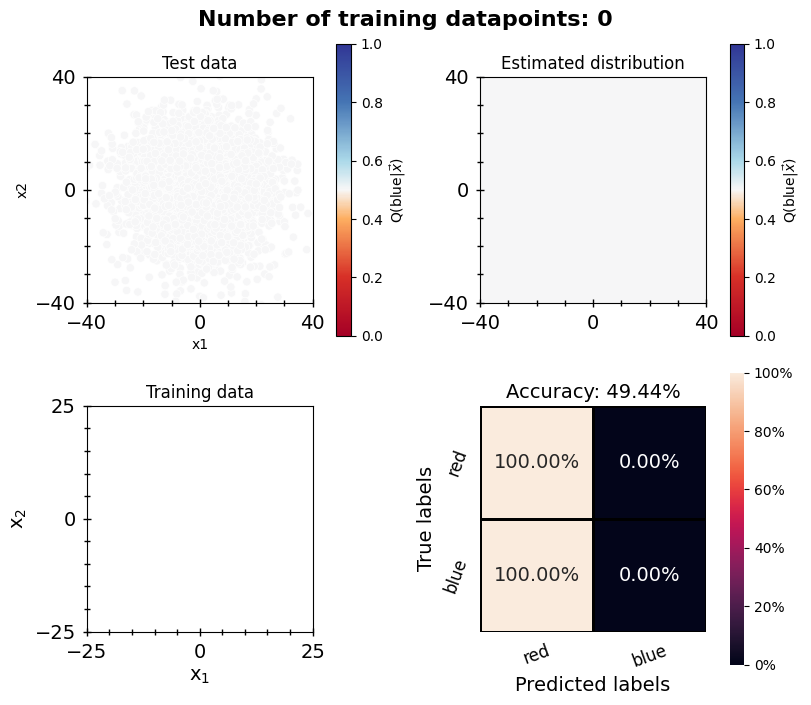

In [ ]:
truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
val_data["Prediction"] = torch.argmax(logits_val, dim=-1).flatten()
val_data["Confidence"] = torch.softmax(logits_val, dim=-1)[:,1] #Get softmax score for blue

truth_grid, logits_grid = predict_classifier(model, grid_dataset, 2, 100, device)
grid_data["Prediction"] = torch.argmax(logits_grid, dim=-1).flatten()
grid_data["Confidence"] = torch.softmax(logits_grid, dim=-1)[:,1] #Get softmax score for blue

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Confidence", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(val_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:0], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: 0", size=16, fontweight="bold")

In [ ]:
n_train = 500
patience = 30
epochs = 100
lr = 0.01
batchsize = 2**11
print(batchsize)

train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=batchsize, epochs = 100, 
                         device = device, optimizer = optimizer, early_stopping=patience)
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

2048


  0%|          | 0/100 [00:00<?, ?it/s]
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [14,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [15,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/sr

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


100%|██████████| 100/100 [00:00<00:00, 558.52it/s]


Text(0.5, 0.98, 'Number of training datapoints: 500')

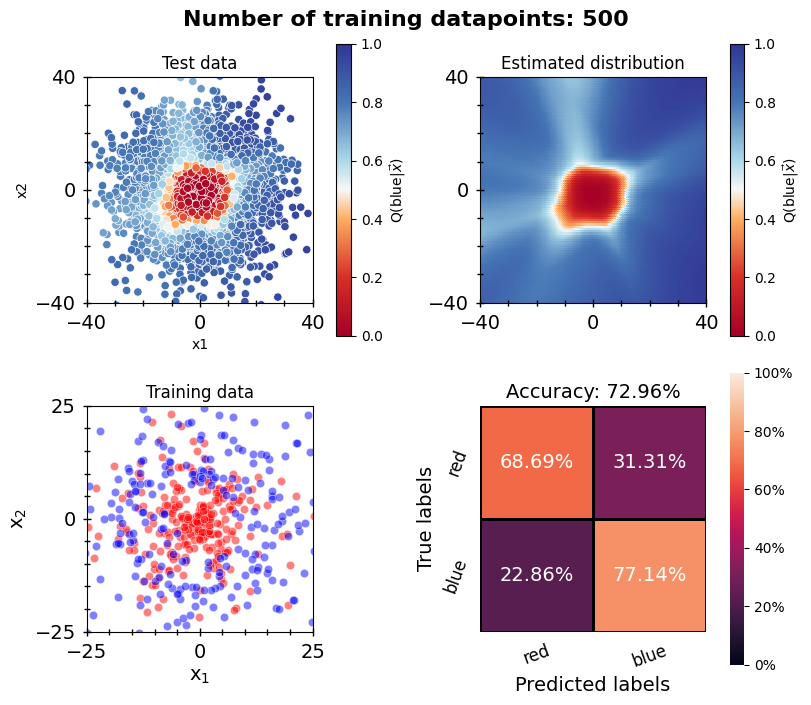

In [ ]:
truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
val_data["Prediction"] = torch.argmax(logits_val, dim=-1).flatten()
val_data["Confidence"] = torch.softmax(logits_val, dim=-1)[:,1] #Get softmax score for blue

truth_grid, logits_grid = predict_classifier(model, grid_dataset, 2, 100, device)
grid_data["Prediction"] = torch.argmax(logits_grid, dim=-1).flatten()
grid_data["Confidence"] = torch.softmax(logits_grid, dim=-1)[:,1] #Get softmax score for blue

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Confidence", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(val_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_train], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")


<Axes: xlabel='r', ylabel='Count'>

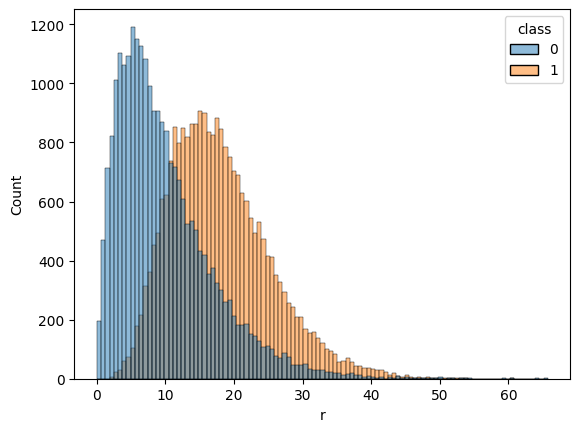

In [ ]:
sn.histplot(train_data, x="r", hue="class")

(0.0, 1.0)

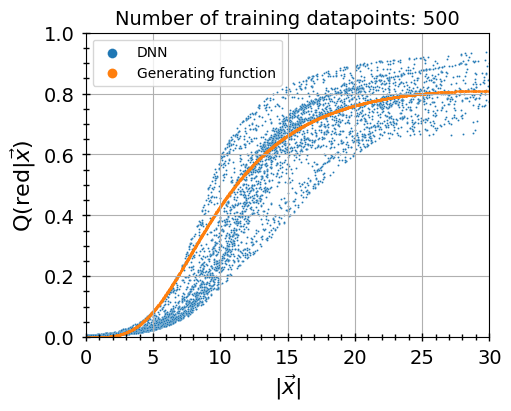

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (5, 4), layout="constrained")
sn.scatterplot(val_data, x="r", y="Confidence", s=2, ax = ax, label ="DNN")
sn.scatterplot(val_data, x="r", y="p_c1_given_r", s=2, ax = ax, label="Generating function", linewidth=0)
#ax.plot(red_bins[0:-1], fraction_blue, label="Empirical estimated distribution", color="red")
ax.set_title(f"Number of training datapoints: {n_train}", fontsize=14)
ax.legend(markerscale=5, fontsize=10)
ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
ax.set_ylabel(r"Q(red|$\vec{x}$)", fontsize=16)
ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
ax.tick_params(which="major", length=6)
ax.minorticks_on()
ax.grid()
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)

In [ ]:
def neg_log_posterior(var0, logits_train, y_train, W):
    # Negative-log-likelihood
    nll = F.cross_entropy(logits_train, y_train) 
    # Negative-log-prior
    nlp = 1/2 * W.flatten().to("cpu") @ (1/var0* torch.eye(W.numel()).to("cpu")) @ W.flatten().to("cpu")
    
    return nll + nlp


def get_covariance(var0, model, train_dataset, device):
    # Outputs the inverse-Hessian of the negative-log-posterior at the MAP estimate
    # This is the posterior covariance
    W = list(model.parameters())[-1]
    truth, logits_train = predict_classifier(model, train_dataset, 2, 100, device)
    class_train = truth.to(torch.long)
    loss = neg_log_posterior(var0, logits_train, class_train, W)
    Lambda = exact_hessian(loss, [W])  # The Hessian of the negative log-posterior
    Sigma = torch.inverse(Lambda).detach().numpy()
    return Sigma


def predict(x_test, Sigma, model):  
    W = list(model.parameters())[-1]
    shape_W = W.shape
    w_map = W.view(-1).data.cpu().numpy()

    model.eval()
    with torch.no_grad():  
        phi = model.cpu().feature_map(x_test.cpu()).numpy()  # Feature vector of x
        m = phi @ w_map  # MAP prediction

        # "Moderate" the MAP prediction using the variance (see MacKay 1992 "Evidence Framework ...")
        # This is an approximation of the expected sigmoid (the so-called "probit approximation")
        v = np.diag(phi @ Sigma @ phi.T)
        est_probs = np.softmax(m/np.sqrt(1 + np.pi/8 * v))
        
    return est_probs

# The weight decay used for training is the Gaussian prior's precision
# Here we work in term of variance, which is just 1/precision.
var0 = 1/5e-4 

# Get the posterior covariance and make prediction
Sigma = get_covariance(var0, model, train_dataset, device)
py = predict(X_test, Sigma, model)

conf = np.maximum(py, 1-py)

100%|██████████| 5/5 [00:00<00:00, 351.64it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 400 is different from 200)